In [1]:
import pybma

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import numpy as np

In [2]:
m = pybma.load_model("../models/ToyModelUnstable.json")
qn = pybma.model_to_qn(m)
p = pybma.check_stability(qn)

print("###Unstable model###")
print(p)

#knock out a variable
m['Model']['Variables'][0]['Formula'] = "0"
qno = pybma.model_to_qn(m)
pko = pybma.check_stability(qno)

print("###Modified Model###")
print(pko)

###Unstable model###
{'ProofProgression': {'stable': False, 'history': [(3, {1: (0, 4), 2: (0, 4), 3: (0, 4)}), (2, {1: (0, 4), 2: (0, 4), 3: (0, 4)}), (1, {1: (0, 4), 2: (0, 4), 3: (0, 4)}), (0, {1: (0, 4), 2: (0, 4), 3: (0, 4)})]}, 'CounterExample': {'Result': 'CExCycle', 'Example': {1: [2, 1, 2, 2, 3, 2, 2], 2: [2, 2, 1, 2, 2, 3, 2], 3: [3, 2, 2, 1, 2, 2, 3]}}}
###Modified Model###
{'ProofProgression': {'stable': True, 'history': [(4, {1: (0, 0), 2: (0, 0), 3: (0, 0)}), (3, {1: (0, 0), 2: (0, 0), 3: (0, 0)}), (2, {1: (0, 0), 2: (0, 0), 3: (0, 0)}), (1, {1: (0, 0), 2: (0, 0), 3: (0, 4)}), (0, {1: (0, 0), 2: (0, 4), 3: (0, 4)})]}, 'CounterExample': None}


In [3]:
#functions to process proof progressions to turn them into a heatmap

def singleton(a):
    if a[0]==a[1]:
        return 1
    else:
        return 0
    
def timeHM(timepoint):
    state = []
    for var in timepoint.keys():
        state.append(singleton(timepoint[var]))
    return state

def timeText(timepoint):
    state = []
    for var in timepoint.keys():
        state.append(str(timepoint[var][0])+"-"+str(timepoint[var][1]))
    return state

In [4]:
def proofProgressionPlot(p,annotate=False):
    # Set font at the start
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
    
    progression = p["ProofProgression"]["history"]
    data = np.fliplr(np.array([ timeHM(time[1]) for time in progression ]).transpose())
    # Create custom colormap with your two colors
    colors = ['#E8D4E8', '#C8E8E0']  # purple-pink and mint-green
    cmap = mcolors.ListedColormap(colors)
    
    # Create figure and plot
    fig, ax = plt.subplots(figsize=(12, 4))
    
    # Use pcolormesh instead of imshow - it handles grid lines better
    im = ax.pcolormesh(data, cmap=cmap, vmin=0, vmax=1, edgecolors='white', linewidth=2)
    
    # Add text to each cell
    if annotate:
        text_data = np.fliplr(np.array([ timeText(time[1]) for time in progression ]).transpose())
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                text = ax.text(j + 0.5, i + 0.5, str(text_data[i, j]),
                              ha="center", va="center", color="black", fontsize=10)
    
    # Invert y-axis to match imshow behavior (top to bottom)
    ax.invert_yaxis()
    
    # Remove all ticks and labels
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)
    
    # Remove spines (borders)
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    plt.tight_layout()
    plt.show()
    

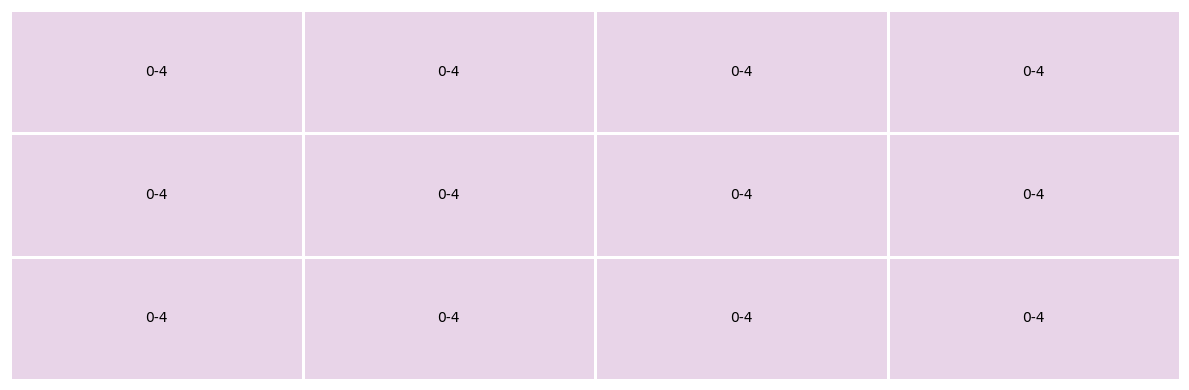

In [5]:
proofProgressionPlot(p,True)

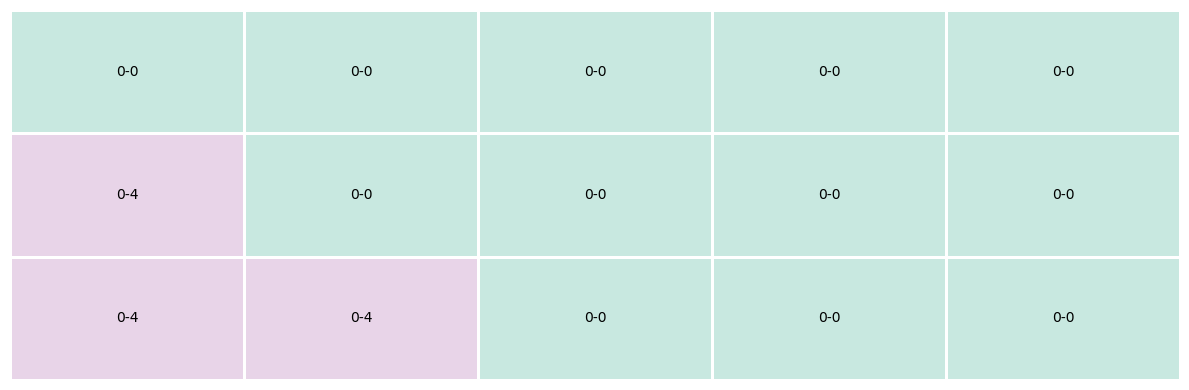

In [6]:
proofProgressionPlot(pko,True)

In [7]:
def simulation_graph(data_dict, title="Simulation Graph", nameMap=None):
    """
    Create a line graph matching the style shown.
    
    Parameters:
    data_dict: Dictionary with keys as labels and values as lists of y-values
               Example: {'a': [0,0,3,3,2,1,1,1,3,3,3], 'b': [0,0,0,3,3,2,1,1,1,3,3], ...}
    title: Graph title
    """
    # Set font properties
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
    plt.rcParams['font.size'] = 11
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot each line
    for label, y_values in data_dict.items():
        x_values = range(len(y_values))
        if nameMap != None:
            label = nameMap[label]
        ax.plot(x_values, y_values, #color=colors.get(label, 'black'), 
                linewidth=2.5, label=label)
    
    # Styling
    ax.set_title(title, fontsize=13, loc='left', pad=15, fontweight='normal')
    ax.grid(True, alpha=0.3, linewidth=0.8)
    ax.set_axisbelow(True)
    
    # Set y-axis to show integer values
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    # Add legend with font styling
    ax.legend(loc='best', frameon=False, fontsize=11)
    
    # Style tick labels
    ax.tick_params(labelsize=10)
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.show()

In [8]:
cexTrace = p['CounterExample']['Example']

In [9]:
nameMap = pybma.model_to_variableIDdict(m)

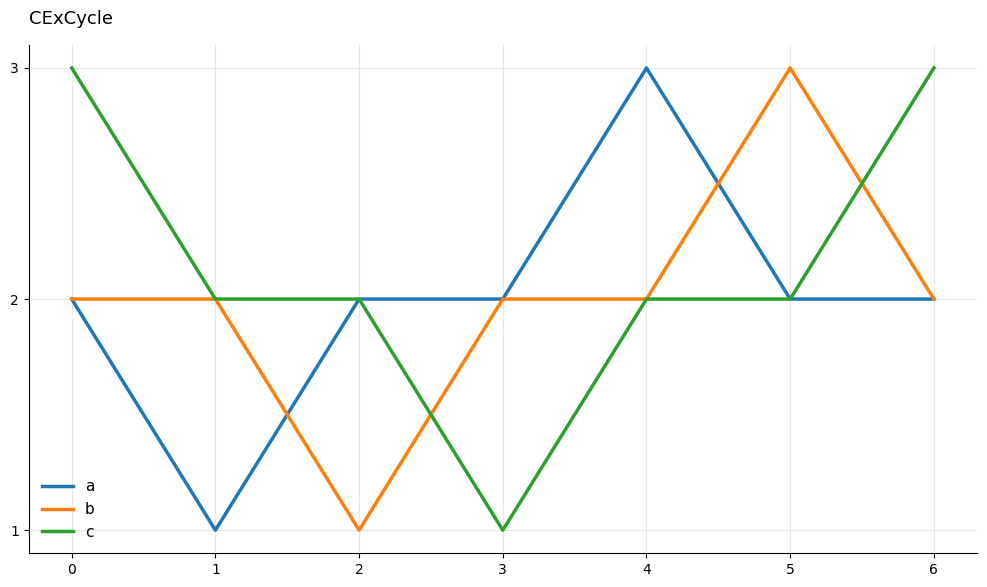

In [10]:
simulation_graph(cexTrace,p['CounterExample']['Result'],nameMap)

In [11]:
def simulation_table(data_dict, title="Initial Value"):
    """
    Create a table view of simulation data.
    - Yellow: value changes from previous timestep
    - Gray: state that repeats a previous state (marks all repetitions except first occurrence)
    - White: value same as previous timestep
    
    Parameters:
    data_dict: Dictionary with keys as labels and values as lists of y-values
               Example: {'a': [1,2,3,3,2,1,1,2,3,3], 'b': [0,1,2,3,3,2,1,1,2,3], ...}
    title: Title for the first column
    """
    # Set font properties
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'Helvetica', 'DejaVu Sans']
    plt.rcParams['font.size'] = 11
    
    # Get number of rows and columns
    num_rows = len(data_dict)
    labels = list(data_dict.keys())
    max_cols = max(len(data_dict[label]) for label in labels)
    
    # Build state for each column
    states = []
    for col_idx in range(max_cols):
        current_state = tuple(data_dict[label][col_idx] for label in labels)
        states.append(current_state)
    
    # Find which state repeats (if any) and mark all its repetitions except first occurrence
    repeated_cols = set()
    state_first_occurrence = {}
    repeating_state = None
    
    for col_idx, state in enumerate(states):
        if state in state_first_occurrence:
            # This state has been seen before, mark this as repeated
            if repeating_state == None or repeating_state == state:
                repeated_cols.add(col_idx)
                repeating_state = state
        else:
            # First time seeing this state
            state_first_occurrence[state] = col_idx
    
    # Create figure - each cell is roughly square
    cell_height = 0.6
    cell_width = 0.6
    header_width = 2.5
    
    fig_width = 2*header_width + max_cols * cell_width + 0.5
    fig_height = (num_rows + 1) * cell_height + 0.5
    
    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    ax.set_xlim(0, 2*header_width + max_cols * cell_width)
    ax.set_ylim(0, (num_rows + 1) * cell_height)
    ax.axis('off')
    
    # Draw init header cell
    header_rect = mpatches.Rectangle(
        (0, num_rows * cell_height), header_width, cell_height,
        edgecolor='white', facecolor='#5a5a5a', linewidth=2
    )
    ax.add_patch(header_rect)
    ax.text(3*header_width/2, (num_rows + 0.5) * cell_height, title,
            ha='center', va='center', color='white', fontsize=12, weight='bold')
    
    # Draw name header cell
    header_rect = mpatches.Rectangle(
        (header_width, num_rows * cell_height), header_width, cell_height,
        edgecolor='white', facecolor='#5a5a5a', linewidth=2
    )
    ax.add_patch(header_rect)
    ax.text(header_width/2, (num_rows + 0.5) * cell_height, "Name",
            ha='center', va='center', color='white', fontsize=12, weight='bold')
    
    # Draw each row
    for row_idx, (label, values) in enumerate(data_dict.items()):
        y_pos = (num_rows - row_idx - 1) * cell_height
        
        # Draw name value cell (white background)
        init_rect = mpatches.Rectangle(
            (0, y_pos), header_width, cell_height,
            edgecolor='#cccccc', facecolor='white', linewidth=1
        )
        ax.add_patch(init_rect)
        
        # Add name value 
        ax.text(header_width/2, y_pos + cell_height/2, str(label),
                ha='center', va='center', color='black', fontsize=11)
        
        # Draw initial value cell (white background) - shows first actual value
        init_rect = mpatches.Rectangle(
            (header_width, y_pos), header_width, cell_height,
            edgecolor='#cccccc', facecolor='white', linewidth=1
        )
        ax.add_patch(init_rect)
        
        # Add initial value (first value from the data)
        ax.text(3*header_width/2, y_pos + cell_height/2, str(values[0]),
                ha='center', va='center', color='black', fontsize=11)
        
        # Draw remaining value cells
        for col_idx in range(len(values)):
            value = values[col_idx]
            #x_pos = header_width + col_idx * cell_width
            
            # For the first column, we already drew it in the header section
            if col_idx == 0:
                continue
            
            # Get previous value
            prev_value = values[col_idx - 1]
            
            # Determine color
            if col_idx in repeated_cols:
                # Gray for repeated state
                color = '#d4d4d4'
            elif value != prev_value:
                # Yellow if value changed
                color = '#f5f5c8'
            else:
                # White if value same as previous
                color = '#ffffff'
            
            # Draw cell (offset by -1 since we skip the first column)
            cell_rect = mpatches.Rectangle(
                (2*header_width + (col_idx - 1) * cell_width, y_pos), cell_width, cell_height,
                edgecolor='#cccccc', facecolor=color, linewidth=1
            )
            ax.add_patch(cell_rect)
            
            # Add value text
            ax.text(2*header_width + (col_idx - 1) * cell_width + cell_width/2, 
                   y_pos + cell_height/2, str(value),
                   ha='center', va='center', color='black', fontsize=11)
    
    plt.tight_layout()
    plt.show()

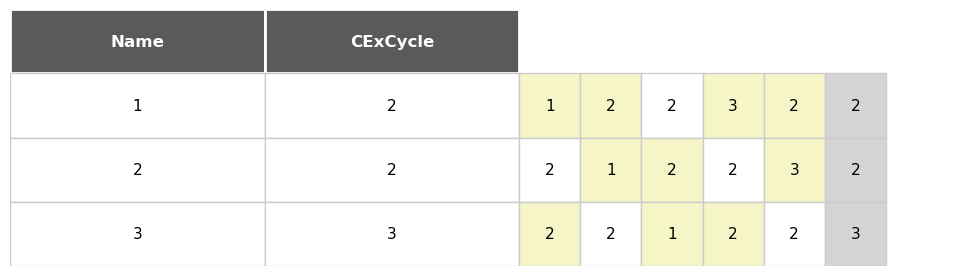

In [12]:
simulation_table(cexTrace,p['CounterExample']['Result'])

In [13]:
simulation = pybma.simulate(qn,steps=30)

In [14]:
print(simulation)

{1: [0, 1, 2, 3, 3, 2, 1, 1, 2, 3, 3, 2, 1, 1, 2, 3, 3, 2, 1, 1, 2, 3, 3, 2, 1, 1, 2, 3, 3], 2: [0, 0, 1, 2, 3, 3, 2, 1, 1, 2, 3, 3, 2, 1, 1, 2, 3, 3, 2, 1, 1, 2, 3, 3, 2, 1, 1, 2, 3], 3: [0, 0, 0, 1, 2, 3, 3, 2, 1, 1, 2, 3, 3, 2, 1, 1, 2, 3, 3, 2, 1, 1, 2, 3, 3, 2, 1, 1, 2]}


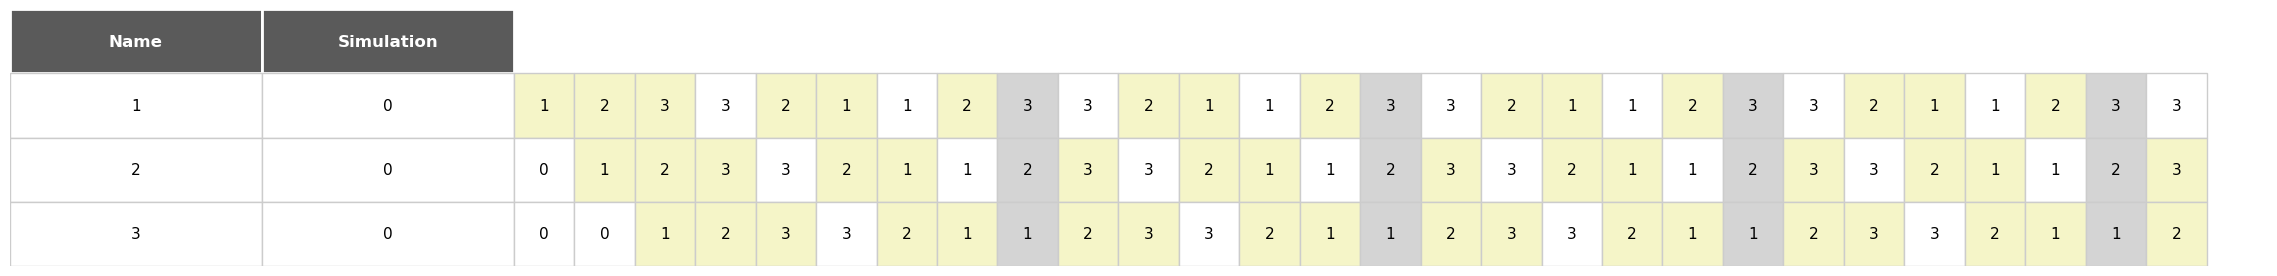

In [15]:
simulation_table(simulation,"Simulation")

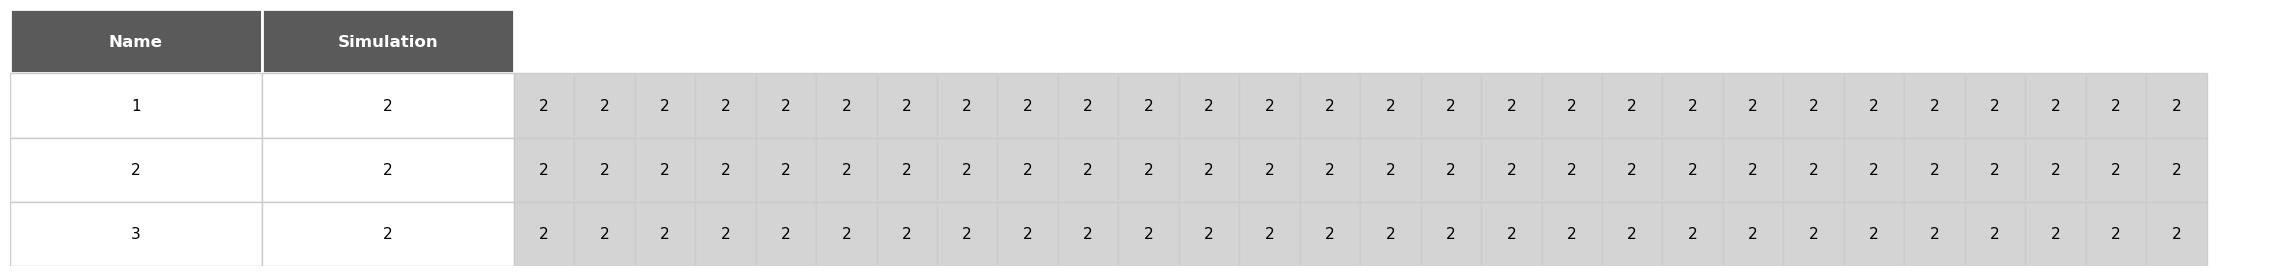

In [16]:
simulation = pybma.simulate(qn,steps=30,initial_values={1:2,2:2,3:2})
simulation_table(simulation,"Simulation")

In [17]:
testLTL = pybma.testQuery("(True)",qn,10)

In [18]:
testLTL

{'LTL': '(True)',
 'query': True,
 'posTrace': {1: [0, 1, 2, 3, 3, 2, 1, 1, 2],
  2: [0, 0, 1, 2, 3, 3, 2, 1, 1],
  3: [0, 0, 0, 1, 2, 3, 3, 2, 1]},
 'negation': False,
 'negTrace': {}}

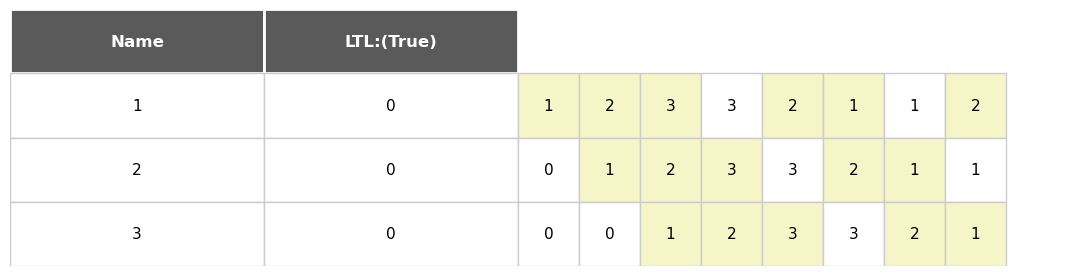

In [19]:
simulation_table(testLTL["posTrace"],"LTL:"+testLTL["LTL"])

In [20]:
findFixpoint = pybma.testQuery("(Eventually SelfLoop)",qn,10)
print(findFixpoint)

{'LTL': '(Eventually SelfLoop)', 'query': True, 'posTrace': {1: [2, 2, 2, 2, 2, 2, 2, 2, 2], 2: [2, 2, 2, 2, 2, 2, 2, 2, 2], 3: [2, 2, 2, 2, 2, 2, 2, 2, 2]}, 'negation': True, 'negTrace': {1: [0, 1, 2, 3, 3, 2, 1, 1, 2], 2: [0, 0, 1, 2, 3, 3, 2, 1, 1], 3: [0, 0, 0, 1, 2, 3, 3, 2, 1]}}


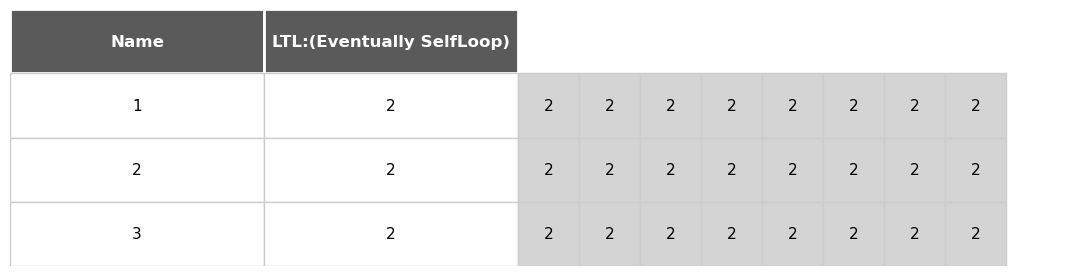

In [21]:
simulation_table(findFixpoint["posTrace"],"LTL:"+findFixpoint["LTL"])

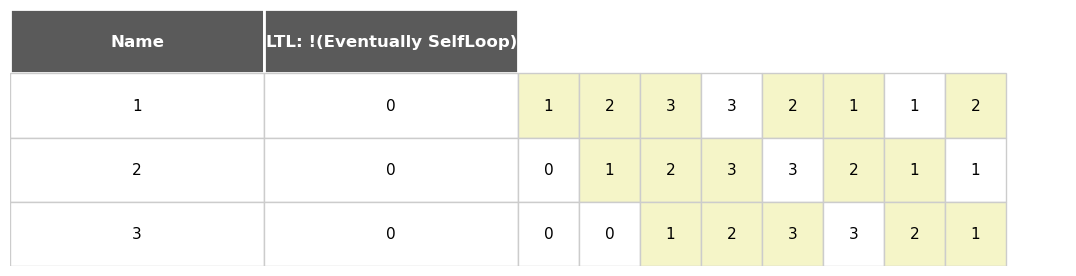

In [22]:
simulation_table(findFixpoint["negTrace"],"LTL: !"+findFixpoint["LTL"])

In [23]:
malformed = pybma.testQuery("(eventually SelfLoop)",qn,10)
print(malformed)

Malformed LTL query: (eventually SelfLoop)
Check paranetheses and capitalisation- for examples and keywords see:
https://github.com/hallba/BioModelAnalyzer/blob/master/BmaLinux/BioCheckAnalyzerMulti/LTL.fs
{}
